In [121]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR


def get_listings():
    return pd.read_csv('../data/processed/listings.csv')

In [122]:
def fill_missing_values_with_random_forest_regression_model(df, column, actual_target_column):
    actual_target_copy = df[actual_target_column].copy()
    df.drop(columns=[actual_target_column], inplace=True)

    train_data = df[df[column].notna()]
    test_data = df[df[column].isna()]

    # Features (exclude the target column)
    X_train = train_data.drop(columns=[column])
    y_train = train_data[column]
    X_test = test_data.drop(columns=[column])

    # Train a regression model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_values = model.predict(X_test)

    # Fill missing values in the original DataFrame
    df.loc[df[column].isna(), column] = predicted_values
    df[actual_target_column] = actual_target_copy
    return df

In [123]:
def fill_missing_values_with_sgd_regressor(df, column, actual_target_column):
    columns_with_nan = df.columns[df.isna().any()].tolist()
    columns_with_nan.remove(column)
    columns_with_nan.remove(actual_target_column)

    train_data = df[df[column].notna()]
    test_data = df[df[column].isna()]

    # Features (exclude the target column)
    X_train = train_data.drop(columns=[column, actual_target_column, *columns_with_nan])
    y_train = train_data[column]
    X_test = test_data.drop(columns=[column, actual_target_column, *columns_with_nan])

    # Train a regression model
    model = SGDRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_values = model.predict(X_test)

    # Fill missing values in the original DataFrame
    df.loc[df[column].isna(), column] = predicted_values
    return df

In [124]:
def fill_missing_values_with_svr(df, column, actual_target_column):
    columns_with_nan = df.columns[df.isna().any()].tolist()
    columns_with_nan.remove(column)
    columns_with_nan.remove(actual_target_column)

    train_data = df[df[column].notna()]
    test_data = df[df[column].isna()]

    # Features (exclude the target column)
    X_train = train_data.drop(columns=[column, actual_target_column, *columns_with_nan])
    y_train = train_data[column]
    X_test = test_data.drop(columns=[column, actual_target_column, *columns_with_nan])

    # Train a regression model
    model = SVR()
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_values = model.predict(X_test)

    # Fill missing values in the original DataFrame
    df.loc[df[column].isna(), column] = predicted_values
    return df

In [125]:
listings = get_listings()
listings_filled = fill_missing_values_with_svr(listings, "price", "avg_rating")

In [126]:
listings_filled["price"].isna().sum()

np.int64(0)

In [127]:
listings = get_listings()
listings["price"].isna().sum()

np.int64(1521)

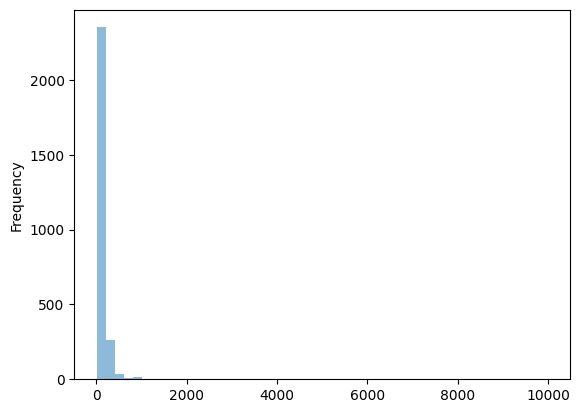

Q95 300.0


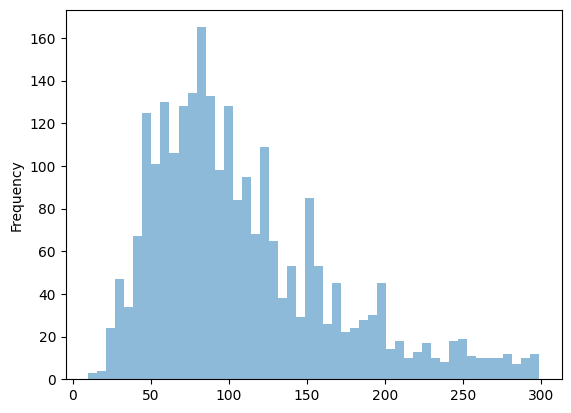

In [128]:
listings["price"].plot(kind="hist", bins=50, alpha=0.5, label="Original")
plt.show()

q95_original = listings["price"].quantile(0.95)
print("Q95", q95_original)
listings[listings["price"] < q95_original]["price"].plot(kind="hist", bins=50, alpha=0.5,
                                                         label="Original (95% quantile)")
plt.show()

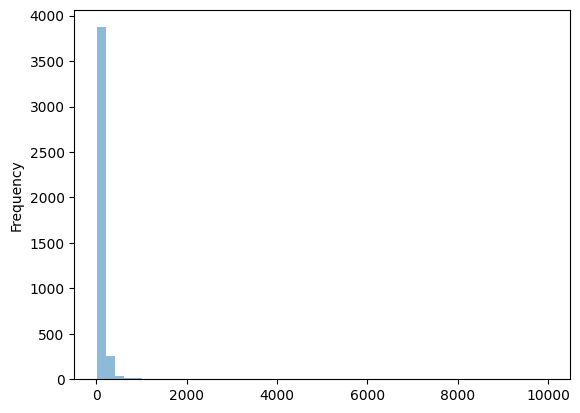

Q95 258.2999999999997


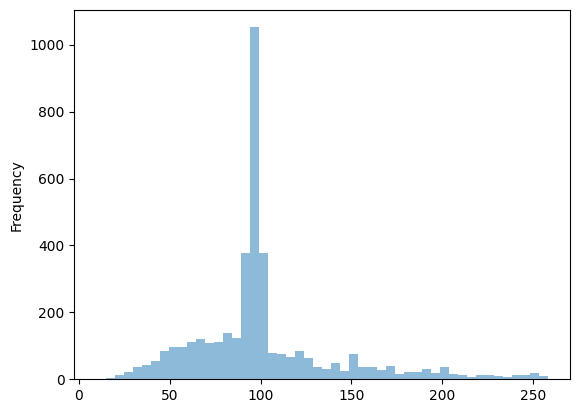

<Axes: ylabel='Frequency'>

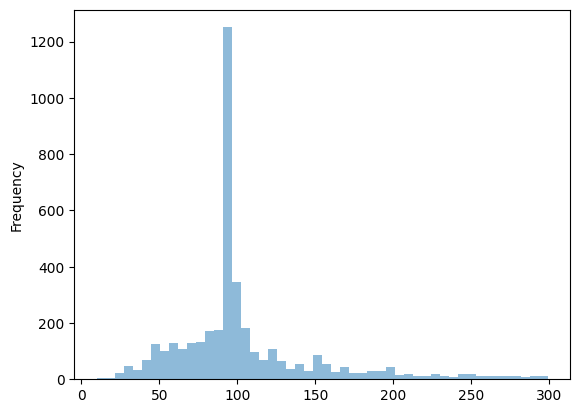

In [129]:
listings_filled["price"].plot(kind="hist", bins=50, alpha=0.5, label="Filled")
plt.show()

q95 = listings_filled["price"].quantile(0.95)
print("Q95", q95)
listings_filled[listings_filled["price"] < q95]["price"].plot(kind="hist", bins=50, alpha=0.5,
                                                              label="Filled (95% quantile)")
plt.show()

listings_filled[listings_filled["price"] < q95_original]["price"].plot(kind="hist", bins=50, alpha=0.5,
                                                                       label="Filled (95% of original quantile)")

In [130]:
print(f"Before Q95 was {q95_original}")
print(f"After using regression model Q95 is {q95}")

quantile = (listings_filled["price"] <= q95_original).sum() / len(listings_filled)
print(f"Now {q95_original} is {quantile:.2f} quantile")

Before Q95 was 300.0
After using regression model Q95 is 258.2999999999997
Now 300.0 is 0.97 quantile


In [131]:
def regression_model_results(listings):
    print(f"Rows: {len(listings)}")
    listings = listings[listings["avg_rating"].notna()]
    Y = listings["avg_rating"]
    X = listings.drop(columns=["avg_rating"])

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = SVR()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Linear regression")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")

    print("-" * 30)

    print("Random model - U(0,5)")
    y_random_pred = np.random.rand(len(y_test)) * 5
    mse_random = mean_squared_error(y_test, y_random_pred)
    r2_random = r2_score(y_test, y_random_pred)
    print(f"Mean Squared Error: {mse_random:.2f}")
    print(f"R-squared: {r2_random:.2f}")

    print("-" * 30)

    print("Random model - U(4,5)")
    y_random_pred = np.random.rand(len(y_test)) + 4
    mse_random = mean_squared_error(y_test, y_random_pred)
    r2_random = r2_score(y_test, y_random_pred)
    print(f"Mean Squared Error: {mse_random:.2f}")
    print(f"R-squared: {r2_random:.2f}")


In [133]:
fill_strategies = [
    # ("No fill", lambda df,col,target: df),
    ("Random forest", fill_missing_values_with_random_forest_regression_model),
    # ("SGD", fill_missing_values_with_sgd_regressor),
    ("SVR", fill_missing_values_with_svr)
]

for name, fill_strategy in fill_strategies:
    print("="*50)
    print(name)
    listings = get_listings()

    target = "avg_rating"
    columns_with_missing_values = listings.columns[listings.isna().any()].tolist()
    columns_with_missing_values.remove(target)

    for c in columns_with_missing_values:
        fill_strategy(listings, c, target)

    regression_model_results(listings)

Random forest
Rows: 4195
Linear regression
Mean Squared Error: 0.08
R-squared: 0.03
------------------------------
Random model - U(0,5)
Mean Squared Error: 7.62
R-squared: -94.31
------------------------------
Random model - U(4,5)
Mean Squared Error: 0.23
R-squared: -1.86
SVR
Rows: 4195
Linear regression
Mean Squared Error: 0.08
R-squared: 0.03
------------------------------
Random model - U(0,5)
Mean Squared Error: 7.20
R-squared: -89.01
------------------------------
Random model - U(4,5)
Mean Squared Error: 0.23
R-squared: -1.91


In [137]:
df = get_listings()
target_col = df["avg_rating"].copy()
df = df.fillna(df.mean())
df["avg_rating"] = target_col
regression_model_results(df)


Rows: 4195
Linear regression
Mean Squared Error: 0.08
R-squared: 0.03
------------------------------
Random model - U(0,5)
Mean Squared Error: 7.15
R-squared: -88.35
------------------------------
Random model - U(4,5)
Mean Squared Error: 0.24
R-squared: -1.96
